In [1]:
using Distributions, PyPlot

In [2]:
### Some Helper Function
#Order quantity
nv_order(dist, b, h) = quantile(dist, b/(b + h))
nv_order(supp, probs, b, h) = supp[nv_order(Categorical(probs), b, h)]

#Takes a data-stream of integers and computes relative frequency
function compute_phat(dat, supp_size) 
    phat = zeros(supp_size)
    for x in dat
        phat[x] += 1 
    end
    phat /= length(dat)
end

shrink(phat, pzero, lam) = lam * phat + (1 - lam) * pzero

shrink (generic function with 1 method)

In [3]:
###
# Generate some categorical distributions from a Dirichlet
# Then generate data from each one
###
#srand(8675309)
const p = 30
const alpha = .1
const h = .5
const b = 1.0

grand_supp = collect(linspace(0, 100, p))
grand_dist = Dirichlet(p, alpha)

#Assume for now that all have same number of data pts N
const N = 20  # num data pts for each subproblem
const K = 100 # num subproblems

#generate a true distribution for each subproblem
#column major
true_probs = zeros(p, K)  # pstar^K

for k = 1:K
    true_probs[:,k] = rand(grand_dist)
end    

##Generate data for each subproblem.  Reinterpret data as an empirical phat^K
phats = zeros(p, K)
for k = 1:K
    dist_k = Categorical(true_probs[:, k])
    dat_k = rand(dist_k, N)
    phats[:, k] = compute_phat(dat_k, p)
end

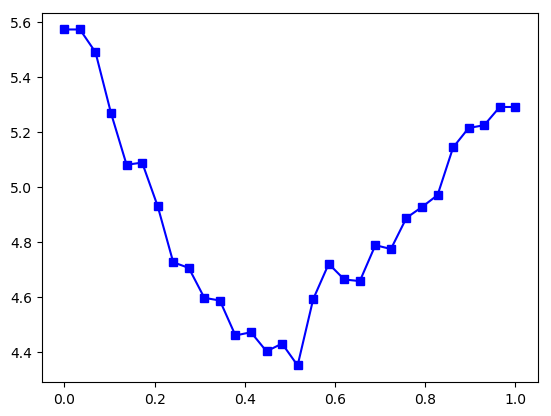

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x124aab710>

In [4]:
lam_grid = linspace(0, 1, 30)
out = zeros(lam_grid)

nv_cost(supp, probs, q) = dot(probs, max.(supp - q, 0))
p_zero = vec(sum(phats, 2)) / K

for (ix, lam) in enumerate(lam_grid)
    for k = 1:K
        #shrink by lambda and find the newsvendor quantile
        q = nv_order(grand_supp, shrink(vec(phats[:, k]), p_zero, lam), b, h)      

        #evaluate against the true cost
        out[ix] += nv_cost(grand_supp, true_probs[:, k], q) / K
    end
end

plot(lam_grid, out, "s-b")

In [62]:
#Notice that there is an optimal amount of shrinkage at .4, and that no shrinkage (lam = 1) is substantively worse (50%)
out[end]/minimum(out) - 1 


0.42824877045742027